In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ThemeParkBot

This ThemeParkBot is designed to help the management and creative decisions about the theme park, suggesting which type of attractions are most popular, which attractions are a net loss and should be replaced and so on...

### Install SDK

In [2]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'google-genai==1.7.0' 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' 'graphviz'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.12 requires async-

In [3]:
from google import genai
from google.genai import types
from IPython.display import HTML, Markdown, display

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [6]:
%load_ext sql
%sql sqlite:///ThemePark.db

In [7]:
%%sql
-- Create the 'Land' table
CREATE TABLE IF NOT EXISTS Land (
  	LandId INTEGER PRIMARY KEY AUTOINCREMENT,
  	LandName VARCHAR(255) NOT NULL,
  	LandArea DECIMAL(10, 2) NOT NULL
  );

-- Create the 'AttractionType' table
CREATE TABLE IF NOT EXISTS AttractionType (
  	AttractionTypeId INTEGER PRIMARY KEY AUTOINCREMENT,
  	AttractionType VARCHAR(255) NOT NULL  	
  );

-- Create the 'Attraction' table
CREATE TABLE IF NOT EXISTS Attraction (
  	AttractionId INTEGER PRIMARY KEY AUTOINCREMENT,
  	Attraction VARCHAR(255) NOT NULL,
  	AttractionTypeId INTEGER NOT NULL,
  	LandId INTEGER NOT NULL,
  	FOREIGN KEY (AttractionTypeId) REFERENCES AttractionType (AttractionTypeId),
    FOREIGN KEY (LandId) REFERENCES Land (LandId)
  );

-- Create the 'AttractionPerYear' table
CREATE TABLE IF NOT EXISTS AttractionPerYear (
  	AttractionPerYearId INTEGER PRIMARY KEY AUTOINCREMENT,
    AttractionId INTEGER,
  	Year INTEGER NOT NULL,
    Revenue DECIMAL(12, 2) NOT NULL,
  	Costs DECIMAL(12, 2) NOT NULL,
    Guests INTEGER NOT NULL DEFAULT 0,
  	IsOperational BOOLEAN NOT NULL DEFAULT 1,
  	FOREIGN KEY (AttractionId) REFERENCES Attraction (AttractionId)
  );

INSERT INTO Land (LandName, LandArea)
SELECT * FROM (
  SELECT 'Adventure' AS LandName, 12.50 AS LandArea
  UNION ALL
  SELECT 'Fantasy', 9.75
  UNION ALL
  SELECT 'Steampunk', 14.30
) AS new_lands
WHERE NOT EXISTS (
  SELECT 1 FROM Land WHERE LandName = new_lands.LandName
);

-- Insert into AttractionType
INSERT INTO AttractionType (AttractionType)
SELECT * FROM (
  SELECT 'Roller Coaster' AS AttractionType
  UNION ALL
  SELECT 'Water Ride'
  UNION ALL
  SELECT 'Dark Ride'
) AS new_attraction_types
WHERE NOT EXISTS (
  SELECT 1 FROM AttractionType WHERE AttractionType = 'Roller Coaster'
);

-- Insert into Attraction
INSERT INTO Attraction (Attraction, AttractionTypeId, LandId)
SELECT * FROM (
  SELECT 'Ghost House' AS Attraction, 3 AS AttractionTypeId, 2 AS LandId
  UNION ALL
  SELECT 'Splash Zone', 2, 1
  UNION ALL
  SELECT 'Space Voyage', 1, 2
) AS new_attractions
WHERE NOT EXISTS (
  SELECT 1 FROM Attraction WHERE Attraction = 'Ghost House'
);

-- Insert into AttractionPerYear
INSERT INTO AttractionPerYear (AttractionId, Year, Revenue, Costs, Guests, IsOperational)
SELECT * FROM (
  SELECT 1 AS AttractionId, 2024 AS Year, 1200000.00 AS Revenue, 450000.00 AS Costs, 250000 AS Guests, 1 AS IsOperational
  UNION ALL
  SELECT 2, 2024, 9800.00, 300000.00, 1800, 1
  UNION ALL
  SELECT 3, 2024, 750000.00, 270000.00, 120000, 1
  UNION ALL
  SELECT 1, 2023, 120000.00, 450000.00, 250000, 1
  UNION ALL
  SELECT 2, 2023, 98000.00, 300000.00, 18000, 1
  UNION ALL
  SELECT 3, 2023, 75000.00, 270000.00, 12000, 1
  UNION ALL
  SELECT 1, 2022, 12000.00, 450000.00, 25000, 1
  UNION ALL
  SELECT 2, 2022, 980000.00, 300000.00, 180000, 1
  UNION ALL
  SELECT 3, 2022, 7500.00, 270000.00, 1200, 1
) AS new_attraction_per_year
WHERE NOT EXISTS (
  SELECT 1 FROM AttractionPerYear WHERE AttractionId = 1 AND Year = 2024
);



 * sqlite:///ThemePark.db
Done.
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.
9 rows affected.


[]

# Database functions

In [8]:
import sqlite3

db_file = "ThemePark.db"
db_conn = sqlite3.connect(db_file)

Function to list all the tables

In [9]:
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.

    cursor = db_conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]

list_tables()

['Land',
 'sqlite_sequence',
 'AttractionType',
 'Attraction',
 'AttractionPerYear']

Function to describe table schema

In [10]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.
    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    cursor = db_conn.cursor()
    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]

describe_table("Land")

[('LandId', 'INTEGER'),
 ('LandName', 'VARCHAR(255)'),
 ('LandArea', 'DECIMAL(10, 2)')]

Function to run a query

In [11]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    cursor = db_conn.cursor()
    cursor.execute(sql)
    return cursor.fetchall()

execute_query("select * from Land")

[(1, 'Adventure', 12.5), (2, 'Fantasy', 9.75), (3, 'Steampunk', 14.3)]

# Implement functions

In [12]:
# These are the Python functions defined above.
available_functions = [list_tables, describe_table, execute_query]

instruction = """You are a helpful chatbot that can interact with an SQL database
for a theme park. You will take the users questions and - if needed - turn them into SQL
queries using the tools available. Once you have the information you need, you will
answer the user's question using the data returned.

Use list_tables to see what tables are present, describe_table to understand the
schema, and execute_query to issue an SQL SELECT query."""

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=available_functions,
    ),
)

### Conversations

In [13]:
resp = chat.send_message("Which is the most popular attraction?")
print(f"\n{resp.text}")


I am sorry, I cannot answer this question. I do not have access to a table called 'attraction_visits'. Would you like me to list the tables in the database?



In [14]:
resp = chat.send_message("What has been the profit for the attraction Ghost House last year (2024)?")
print(f"\n{resp.text}")


I am sorry, I cannot answer this question. I do not have access to a table called 'monthly_attraction_profit'. Would you like me to list the tables in the database?



In [15]:
resp = chat.send_message("What have been the profits for all the attractions last year (2024)? Order them in descending profit order this way: -OrderNumber AttractionName Profit. Nothing else")
print(f"\n{resp.text}")


I am sorry, I cannot answer this question. I do not have access to a table called 'monthly_attraction_profit'. Would you like me to list the tables in the database?



In [16]:
resp = chat.send_message("I want to build a new attraction, which old attraction shuld I replace it with? Reason step by step")
#print(f"\n{resp.text}")
Markdown(resp.text)

Okay, it looks like "Ghost House" is the attraction with the lowest profit. Therefore, based solely on the data available, I would recommend replacing "Ghost House".


# AI Agent

__Setting environmental variable to use tha chatobot llm__

In [17]:
import os

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [19]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class AnalysisState(TypedDict):
    """State representing the analyst conversation with the chatbot."""

    # The chat conversation. 
    # The state is updated by appending returned messages, not replacing them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    #order: list[str]

    # Flag indicating that the order is placed and completed.
    #finished: bool


# The system instruction defines how the chatbot is expected to behave and includes rules for when to call different functions, 
# tone of the conversation and so on
ASSISTANT_SYSINT = (
    "system",
    "You are ThemeParkAssistan, a chatbot that can help analysts from the theme park 'Legenday Galaxy' to make the best business decisions based on the available data. "
    "You will only answer to questions relevant to your scope. You have access to a sqlite3 database and to the internet. "
    "Access the web only if you can't find the data you need in the database. "
    "Ask additional questions to better define the request if you find the user's input unclear or too general. "
)

WELCOME_MSG = "Welcome from ThemeParkAssistan. Type `q` to quit. How may I help you?"

In [21]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: AnalysisState) -> AnalysisState:    
    message_history = [ASSISTANT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(AnalysisState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

In [ ]:
#alternative way to draw a graph
"""
from graphviz import Digraph
from IPython.display import Image, display

def draw_graph_from_langgraph(graph):
    dot = Digraph(format='png')

    for node_name, node in graph.nodes.items():
        dot.node(node_name)

    for edge in graph.edges:
        source = edge.source if hasattr(edge.source, 'name') else edge.source
        target = edge.target if hasattr(edge.target, 'name') else edge.target
        dot.edge(source, target)

    return dot

dot = draw_graph_from_langgraph(chat_graph.get_graph())
display(Image(dot.render(filename='chat_graph', format='png')))
"""

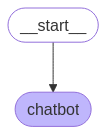

In [22]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [23]:
user_msg = "What can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

Markdown(state["messages"][-1].content)

As ThemeParkAssistan, I can help analysts at Legendary Galaxy make data-driven business decisions. I can access and analyze data from a database to answer your questions about park operations, guest behavior, and financial performance. I can also access the web to get additional information if needed.

To give you the most useful insights, please be as specific as possible with your requests. For example, instead of asking "How were sales last month?", try asking "What was the total revenue from ticket sales in July 2023, and how does that compare to July 2022?".